# Radial Basis Function : split linear and radial solve

Radial basis function as implemented in the Verbs And Adverbs paper, where they first solve for linear coefficients and then radial basis coefficients for the residuals.

Notebook by Jerome Eippers, 2024

In [1]:
%matplotlib widget
import numpy as np
from ipywidgets import widgets, interact
from matplotlib import pyplot as plt

## Verbs And Adverbs


Because the paper talks about DOF and multidimensional adverbe space, we will use points on a grid as multidimensional adverbs (right, left, up, down) and colors as DOF (R, G, B)

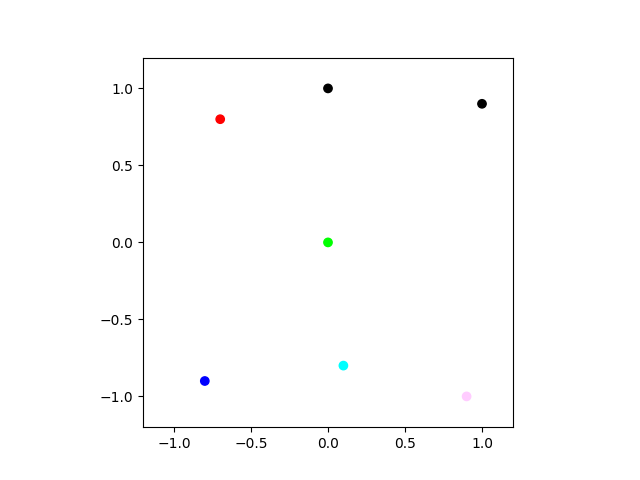

In [2]:
points = np.array([
    [-0.7, .8],
    [-0.8, -.9],
    [0, 1],
    [0, 0],
    [0.1, -.8],
    [1, .9],
    [.9, -1]
])

data = np.array([
    [1,0,0],
    [0,0,1],
    [0, 0, 0],
    [0, 1, 0],
    [0, 1, 1],
    [0,0,0],
    [1,.8,1],
])

plt.figure()
plt.scatter(points[:,0], points[:,1], color=data)
plt.axis('square')
plt.ylim(-1.2, 1.2)
plt.xlim(-1.2, 1.2)
plt.show()

In [3]:
adverbs = np.zeros([points.shape[0], 4])
adverbs[:, 0] = np.maximum(points[:, 0], 0)
adverbs[:, 1] = np.minimum(points[:, 0], 0)
adverbs[:, 2] = np.maximum(points[:, 1], 0)
adverbs[:, 3] = np.minimum(points[:, 1], 0)
adverbs = np.abs(adverbs)
adverbs

array([[0. , 0.7, 0.8, 0. ],
       [0. , 0.8, 0. , 0.9],
       [0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. ],
       [0.1, 0. , 0. , 0.8],
       [1. , 0. , 0.9, 0. ],
       [0.9, 0. , 0. , 1. ]])

## Interpolated values

The paper is multidimensional with number of keyframe plus number of dof.  We will simplify it using the four colors as dof.

Let $c$ be our color dof and $i$ the number of examples (points in our case).  
Let $j$ be the number of adverbs (4 in our case : Left, Right, Up, Down).

The interpolated colors $b_c$ for a point $\textbf{p}$ is defined as :

$$
b_c(\textbf{p}) = \sum_{i=1}^{NumExamples} r_{ic} R_i(\textbf{p}) + \sum_{j=0}^{NumAdverbs} a_{cj} A_j(\textbf{p})
$$



## Linear approximation

The linear basis functions are simply $A_j(p) = p_j$ the $j^{th}$ component of $p$, and $A_0(p) = 1$.  
An ordinary least squares solution determines the NumAdverbs + 1 linear coefficients, $a_{cj}$, that minimize the sum of squared errors between

$$
\tilde{\textbf{b}_c}(p_i) = \sum_{j=0}^{NumAdverbs} a_{cj} A_j(p_i)
$$

and the actual $b_c(p_i)$ where $p_i$ is the adverb setting for the $i^{th}$ example point.

In [4]:
adverb_matrix = np.column_stack([np.ones(adverbs.shape[0]), adverbs])

# one linear coefficients per DOF (R G B)
linear_coefficients = np.linalg.lstsq(adverb_matrix, data, rcond=None)[0]
linear_coefficients

array([[-0.00184266,  1.0472373 ,  0.02138705],
       [ 0.43796263, -0.12287277, -0.09579052],
       [ 0.55624226, -0.79007068, -0.05399018],
       [ 0.04053598, -0.92837373,  0.02395957],
       [ 0.07154178, -0.21970388,  1.13265413]])

Let's preview the linear interpolation.

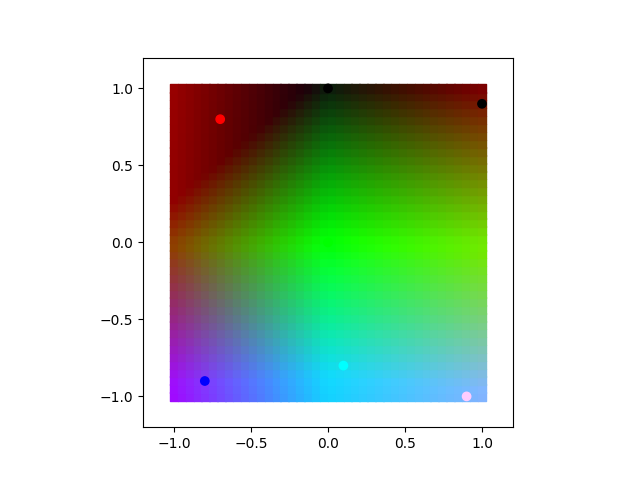

In [5]:
i = np.linspace(-1,1,40)
interpolation_positions = np.zeros([40*40,2])
x, y = np.meshgrid(i,i)
interpolation_positions[:, 0], interpolation_positions[:, 1] = x.flatten(), y.flatten()

interpolation_adverbs = np.zeros([interpolation_positions.shape[0], 4])
interpolation_adverbs[:, 0] = np.maximum(interpolation_positions[:, 0], 0)
interpolation_adverbs[:, 1] = np.minimum(interpolation_positions[:, 0], 0)
interpolation_adverbs[:, 2] = np.maximum(interpolation_positions[:, 1], 0)
interpolation_adverbs[:, 3] = np.minimum(interpolation_positions[:, 1], 0)
interpolation_adverbs = np.abs(interpolation_adverbs)

interpolation_adverbs_data = np.column_stack([np.ones(interpolation_adverbs.shape[0]), interpolation_adverbs])

linear_color = np.dot(interpolation_adverbs_data, linear_coefficients)
    
plt.figure()
plt.scatter(interpolation_positions[:,0], interpolation_positions[:,1], color=np.minimum(np.maximum(linear_color,0), 1), marker='s')
plt.scatter(points[:,0], points[:,1], color=data)
plt.axis('square')
plt.ylim(-1.2, 1.2)
plt.xlim(-1.2, 1.2)
plt.show()

### Residuals

for each points we can compute the residuals that the linear coeficients do not approximate properly.
$$
\bar{\textbf{b}}_c(p_i) = \textbf{b}_c(p_i) - \tilde{\textbf{b}}_c(p_i)
$$

In [6]:
residuals = data - np.dot(adverb_matrix, linear_coefficients)
residuals

array([[ 0.58004429,  0.24851116, -0.00276158],
       [-0.50753876, -0.21744726,  0.00241638],
       [-0.03869332, -0.11886357, -0.04534662],
       [ 0.00184266, -0.0472373 , -0.02138705],
       [-0.09918703,  0.14081308,  0.0820687 ],
       [-0.47260235, -0.08882817,  0.05283986],
       [ 0.53613451,  0.08305207, -0.0678297 ]])

## Radial Basis Functions

It is the job of the radial basis to interpolate the residuals.

we chose to use a radial basis with a cross section of a dilated cubic B-spline, $B(d / \alpha)$.  
The cubic B-spline has a radius of 2.0.

In [7]:
def B3 (x):
    x1 = x-1
    bezier = (1.0/6.0) * ( 1.0 - x1 )**3
    bezier[x>2.0] = 0
    bezier[x<1.0] = (1.0/6.0)*(3*(x**3)-6*(x**2)+4)[x<1.0]
    return bezier

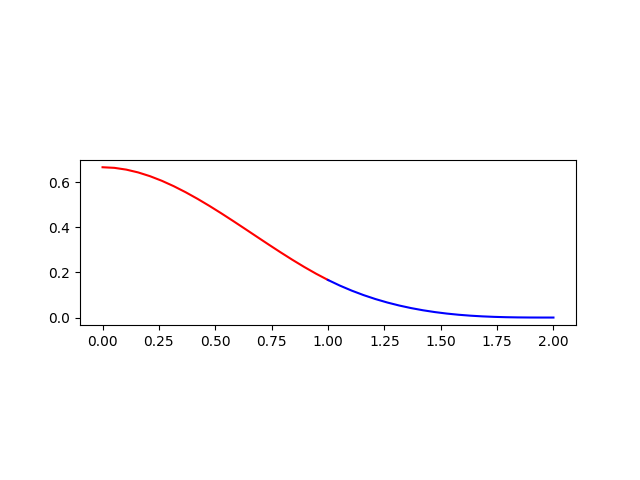

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.linspace(0,1,20), B3(np.linspace(0,1,20)), 'r')
ax.plot(np.linspace(1,2,20), B3(np.linspace(1,2,20)), 'b')
ax.set_aspect('equal')

The dilation factor, $1/\alpha$, is chosen for each example motion to create a support radius for the B-spline equal to twice the Euclidean distance to the nearest other example motion.  
For $\alpha = 1$, the cubic B-spline has a radius of 2.0, thus $\alpha$ is simply the minimum separation to the nearest other example in the adverb space.

The coefficients, $r_{c}$, can now be found for each colors by solving the linear system,
$$
\textbf{D}\textbf{r}_{c} = \bar{\textbf{b}}_c
$$

Where $\textbf{r}_{c}$ is a vector of the $r_{ic}$ terms for a fixed i, and D is a square matrix with terms equal to the value of the radial basis function centered on motion $i_1$ at the location of motion $i_2$. Thus

$$
\textbf{D}_{i_1,i_2} = B_{i_1} \left( \frac{R_{i_1}(\textbf{p}_{i_2})}{\alpha_{i_1}} \right)
$$

In [9]:
c = np.swapaxes(adverbs[np.newaxis, ...], 0, 2)
r = np.swapaxes(adverbs.T[np.newaxis, ...], 0, 1)
distances = np.sqrt(np.sum((c - r)**2, axis=0))
distances

array([[0.        , 1.2083046 , 0.72801099, 1.06301458, 1.33416641,
        1.22474487, 1.71464282],
       [1.2083046 , 0.        , 1.56524758, 1.20415946, 0.81240384,
        1.80554701, 1.2083046 ],
       [0.72801099, 1.56524758, 0.        , 1.        , 1.28452326,
        1.00498756, 1.67630546],
       [1.06301458, 1.20415946, 1.        , 0.        , 0.80622577,
        1.3453624 , 1.3453624 ],
       [1.33416641, 0.81240384, 1.28452326, 0.80622577, 0.        ,
        1.50332964, 0.82462113],
       [1.22474487, 1.80554701, 1.00498756, 1.3453624 , 1.50332964,
        0.        , 1.34907376],
       [1.71464282, 1.2083046 , 1.67630546, 1.3453624 , 0.82462113,
        1.34907376, 0.        ]])

In [10]:
alphas = np.zeros([adverbs.shape[0]])
for i in range(adverbs.shape[0]):
    alphas[i] = np.min(distances[i, np.arange(adverbs.shape[0]) != i])
alphas

array([0.72801099, 0.81240384, 0.72801099, 0.80622577, 0.80622577,
       1.00498756, 0.82462113])

In [11]:
distances = distances / alphas[np.newaxis, :]
distances

array([[0.        , 1.48732014, 1.        , 1.31850731, 1.65482976,
        1.2186667 , 2.07930984],
       [1.65973401, 0.        , 2.15003291, 1.49357599, 1.00766295,
        1.79658642, 1.46528455],
       [1.        , 1.92668659, 0.        , 1.24034735, 1.59325501,
        1.        , 2.03281896],
       [1.46016282, 1.48221783, 1.37360564, 0.        , 1.        ,
        1.33868563, 1.63149156],
       [1.8326185 , 1.        , 1.76442839, 1.        , 0.        ,
        1.4958689 , 1.        ],
       [1.68231646, 2.22247473, 1.38045658, 1.66871669, 1.86465093,
        0.        , 1.63599223],
       [2.35524305, 1.48732014, 2.30258264, 1.66871669, 1.02281662,
        1.34237856, 0.        ]])

In [12]:
D = B3(distances)
D

array([[6.66666667e-01, 2.24588497e-02, 1.66666667e-01, 5.27512003e-02,
        6.85407384e-03, 7.94982849e-02, 0.00000000e+00],
       [6.56605297e-03, 6.66666667e-01, 0.00000000e+00, 2.16466960e-02,
        1.62864478e-01, 1.40277677e-03, 2.54810276e-02],
       [1.66666667e-01, 6.56748408e-05, 6.66666667e-01, 7.30623990e-02,
        1.12154157e-02, 1.66666667e-01, 0.00000000e+00],
       [2.62202675e-02, 2.31360930e-02, 4.09630482e-02, 6.66666667e-01,
        1.66666667e-01, 4.82028409e-02, 8.34048050e-03],
       [7.81575824e-04, 1.66666667e-01, 2.17880114e-03, 1.66666667e-01,
        6.66666667e-01, 2.13539992e-02, 1.66666667e-01],
       [5.34358695e-03, 0.00000000e+00, 3.96336427e-02, 6.05964843e-03,
        4.13251666e-04, 6.66666667e-01, 8.03860519e-03],
       [0.00000000e+00, 2.24588497e-02, 0.00000000e+00, 6.05964843e-03,
        1.55516674e-01, 4.73998144e-02, 6.66666667e-01]])

In [13]:
radial_coefficients = np.linalg.solve(D, residuals)
radial_coefficients

array([[ 1.01103084,  0.47255023,  0.01272003],
       [-0.76182174, -0.41051902, -0.03382113],
       [-0.13675144, -0.25681627, -0.08758631],
       [ 0.08549149, -0.13505674, -0.07682928],
       [-0.18842314,  0.3342144 ,  0.18560102],
       [-0.72068259, -0.12158953,  0.08674927],
       [ 0.92428389,  0.0703165 , -0.14937077]])

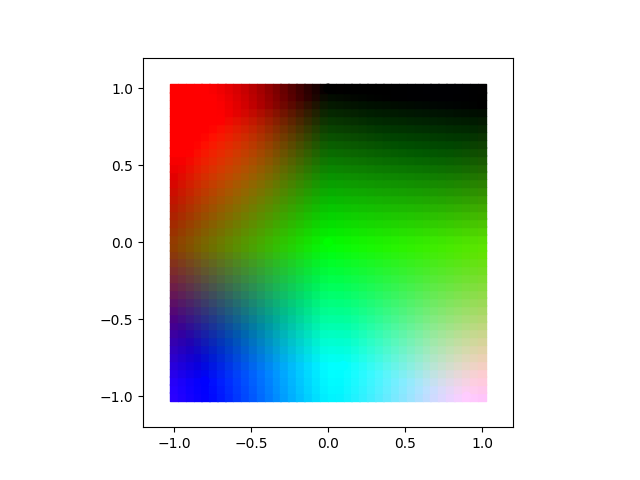

In [14]:
c = np.swapaxes(interpolation_adverbs[np.newaxis, ...], 0, 2)
r = np.swapaxes(adverbs.T[np.newaxis, ...], 0, 1)
interpolation_distance = np.sqrt(np.sum((c - r)**2, axis=0))

interpolation_distance = interpolation_distance / alphas[np.newaxis, :]
interpolation_D = B3(interpolation_distance)

interpolated_rbf = np.dot(interpolation_D, radial_coefficients)
final_color = linear_color + interpolated_rbf

plt.figure()
plt.scatter(interpolation_positions[:,0], interpolation_positions[:,1], color=np.minimum(np.maximum(final_color,0), 1), marker='s')
plt.scatter(points[:,0], points[:,1], color=data)
plt.axis('square')
plt.ylim(-1.2, 1.2)
plt.xlim(-1.2, 1.2)
plt.show()

# Functions for the paper

In [15]:
class RBF:
    
    @staticmethod
    def B3 (x):
        x1 = x-1
        bezier = (1.0/6.0) * (-(x1**3) + 3*(x1**2) - 3*x1 + 1)
        bezier[x>2.0] = 0
        bezier[x<1.0] = (1.0/6.0)*(3*(x**3)-6*(x**2)+4)[x<1.0]
        return bezier
        
    
    def __init__(self, adverbs):
        """
        param adverbs : tensor of shape [i, j] with i the number of data point and j the number of adverb
        """
        self._adverbs = adverbs
        c = np.swapaxes(adverbs[np.newaxis, ...], 0, 2)
        r = np.swapaxes(adverbs.T[np.newaxis, ...], 0, 1)
        distances = np.sqrt(np.sum((c - r)**2, axis=0))
        
        self._alphas = np.zeros([adverbs.shape[0]])
        for i in range(adverbs.shape[0]):
            self._alphas[i] = np.min(distances[i, np.arange(adverbs.shape[0]) != i])
        
        self._D = RBF.B3(distances / self._alphas[np.newaxis, :])
        self._linear_adverbs = np.column_stack([np.ones(adverbs.shape[0]), adverbs])
        
        
    def fit(self, p):
        """
        param p : tensor of shape [i, ...] with i the number of datapoints and the value of each dof
        returns a tuple with a tensor for the linear coefficients and a tensor for the radial coefficients
        """
        linear_coefficients = np.linalg.lstsq(self._linear_adverbs, p, rcond=None)[0]
        residuals = p - np.dot(self._linear_adverbs, linear_coefficients)
        radial_coefficients = np.linalg.solve(self._D, residuals)
        
        return linear_coefficients, radial_coefficients

    
    def __call__(self, linear_coefficients, radial_coefficients, p):
        """
        param linear_coefficients : the linear coefficients returned by the fit
        param radial_coefficients : the radial_coefficients returned by the fit
        param p : tensor of shape [i, j] with i being the number of points to interpolate et j beeing the adverbs values
        return : a tensor with all the interpolated values
        """
        linear = np.dot(np.column_stack([np.ones(p.shape[0]), p]), linear_coefficients)
        
        c = np.swapaxes(p[np.newaxis, ...], 0, 2)
        r = np.swapaxes(self._adverbs.T[np.newaxis, ...], 0, 1)
        D = RBF.B3(np.sqrt(np.sum((c - r)**2, axis=0)) / self._alphas[np.newaxis, :])

        return linear + np.dot(D, radial_coefficients)
        

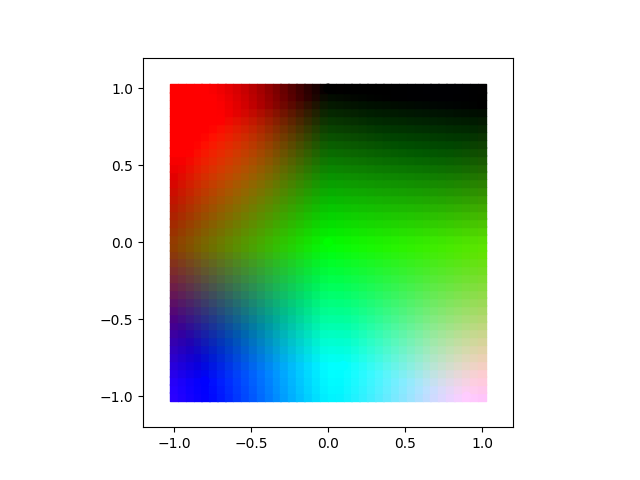

In [16]:
colors_rbf = RBF(adverbs)
linear, radial = colors_rbf.fit(data)
interpolated_colors = colors_rbf(linear, radial, interpolation_adverbs)
    
plt.figure()
plt.scatter(interpolation_positions[:,0], interpolation_positions[:,1], color=np.minimum(np.maximum(interpolated_colors,0), 1), marker='s')
plt.scatter(points[:,0], points[:,1], color=data)
plt.axis('square')
plt.ylim(-1.2, 1.2)
plt.xlim(-1.2, 1.2)
plt.show()

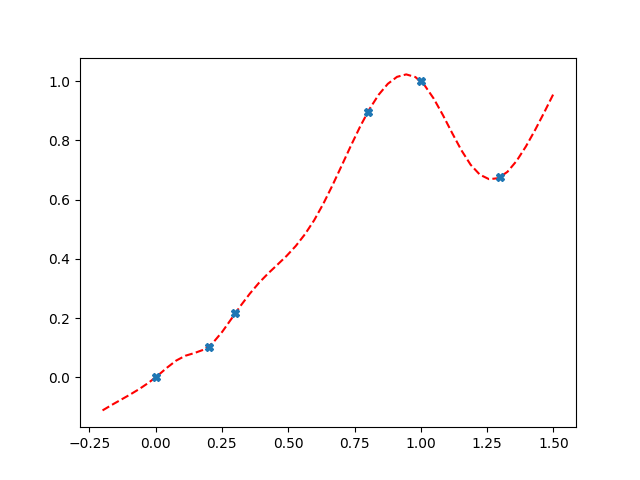

In [17]:
def example_function(x):
    return -2*x**3 + 3*x**2 

xs = np.array([0, .2, .3, .8, 1.0, 1.3])
ys = example_function(xs)

single_rbf = RBF(xs[:, np.newaxis])
coeffs = single_rbf.fit(ys)

plot_x = np.linspace(-0.2, 1.5, 50)
plot_y = single_rbf(*coeffs, plot_x[:, np.newaxis])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(plot_x, plot_y, '--r')
ax.plot(xs, ys, 'X')